# Image analysis I (2023)
## Lab 2: Logistic Regression classifier & Pytorch basics

__Enter your data:__

| Group __03__ | Name  | Matr.-nr. |
|-|-|-|
|   Member 1  | Chengliang Li | 10043349 |
|   Member 2  | Tingde Liu | 10050301 |
|   Member 3  | Yahui Zhang | 10050017 |

`In this lab, you will learn how to implement Logistic Regression classifiers using both the Scikit-learn and Pytorch frameworks and how to apply them to randomly generated data samples and existing benchmark datasets for classification purposes.`

Required __libraries__ for this lab can be installed by:

__1__. running the following command in a code cell ``!conda install numpy matplotlib scikit-learn`` if not installed already, and 

__2__. visiting and following the instructions at [pytorch.org](https://pytorch.org/get-started/locally/) to see how __Pytorch__ and __Torchvision__ modules can be installed. The CUDA tab refers to the support of GPUs. Unless you have experience with the CUDA framework select `None` here.

Required __imports__ and __settings__ for this lab:

In [42]:
# IMPORTS
import lab                                      # Given functions
import numpy as np                              # Numerical computations
from sklearn.metrics import confusion_matrix
import matplotlib                               # Plots
import matplotlib.pyplot as plt     
import torch                                    # PyTorch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from matplotlib.patches import Ellipse

# GLOBAL SETTINGS
PlotSize = 7                                    # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize] 
CMAP = plt.cm.Accent                            # Color mapping 
np.set_printoptions(precision=3)                # Array print precision
np.random.seed(0)

## Exercise 1: Discriminative Probabilistic Classifiers


In this exercise, we will use the toy dataset we generated in the first lab. 
__Run__ the next cell to load the data. 

If you encounter problems with *pickle* package while loading the file, check the version of *numpy*. You may need to install *numpy==1.24.3* with the command: ``!conda install numpy==1.24.3``. This is because the file was generated by the indicated numpy version.

In [43]:
import pickle
    
# LOAD TOY DATASET
with open('./Data/toy_data.pickle', 'rb') as file:
    Xtoy, ytoy, Xtoy_t, ytoy_t = pickle.load(file)
    
# Define the training set features, training set labels,  test set features, test set labels
X, y, X_t, y_t = Xtoy, ytoy, Xtoy_t, ytoy_t

# Check whether the data loading is successfully completed:

print(f'Training set features: {X.shape}')
print(f'Training set labels: {y.shape}')
print(f'Testing set features: {X_t.shape}')
print(f'Testing set labels: {y_t.shape}')

Training set features: (1025, 2)
Training set labels: (1025,)
Testing set features: (1025, 2)
Testing set labels: (1025,)


### Exercise 1.1: Logistic regression
In the next cell, starter code for a class implementing Logistic Regression is given. The class design is again adapted from the scikit-learn module. 

__Complete__ the method ``fit(...)`` that iteratively determines the weights of the classifier.

__Note__ that the weights are internally stored in a 2D array (for faster inference). In the missing part of the method you can treat $\nabla E$ as column vector (like in the lecture). The reshaping is already implemented.

In [44]:
class LogReg():
    def __init__(self, num_classes, num_features, sigma=None):
        # Initializes the classifier
        #  num_classes: number of classes
        #  num_features: number of features (length of each feature vector)
        #  sigma: regularization term or None for training without regularization
        
        self.num_classes = M = num_classes
        self.num_features_w_bias = F = num_features + 1  # Internaly the bias is handled as additional feature   
        self.weights = np.random.uniform(size=(M, F))    # Init. weights using random normally distributed values
        self.sigma = sigma
    
    def fit(self, X, y, max_iter=100, crit=0.0001):
        # Computes gradient and Hesse matrix for each class using ML
        # update the weights using Newton-Raphson method
        #  X: feature_vectors [num_feature_vectors x num_features]
        #  y: corresponding labels [num_feature_vectors]
        #  max_iter: maximum number of iterations
        #  crit: stopping criterion L2 of nabla_E
        
        X = np.copy(X) # to prevent errors due to modifications of these arrays
        y = np.copy(y)
        
        X = np.hstack((np.ones((X.shape[0],1)), X))      # Add bias feature 
        N, F = X.shape                                   # N: num_samples
        M = self.num_classes 

        for it in range(max_iter):
            nabla_E = np.zeros(((M-1)*F, 1))             # Init. nabla_E
            H = np.zeros(((M-1)*F, (M-1)*F))             # Init. H
            
            ##########################################################
            
            # YOUR CODE GOES HERE!
            #
            # 1. Get predictions Y
            # 2. Update nabla_E and H
            # 3. Add regularization if sigma is not None

            y_nk = np.zeros((N, M)) #（1025,4）
            for xi, x in enumerate(X):
                a = np.dot(self.weights, x) 
                eWx = np.exp(a)
                y_nk[xi] = eWx/np.sum(eWx)

            Y_predict = np.argmax(y_nk, axis=1)     # get the predict from the posterior   
            
            # get t_nk, if posteriors is correct, set to 1, if not 0
            t_nk = np.zeros_like(y_nk)              # 1025,4    0010 
            for n in range(N):
                if y[n] == Y_predict[n]:
                    t_nk[n, Y_predict[n]] = 1

            ############################# 1st way to compute gradient #######################

            # gradient = np.zeros_like(self.weights)
            # for j in range(M):
            #     var_3 = 0
            #     for xi, x in enumerate(X):
            #         var_1 = y_nk[xi][j] - t_nk[xi][j]
            #         var_2 = var_1 * x
            #         var_3 += var_2
                    
            #     gradient[j] =  var_3

            ############################# 2nd way to compute gradient #######################
            gradient = np.dot((y_nk - t_nk).T, X)   #（4,3）

            # print(gradient)

            # compute the Hessian Matrix
            I = np.eye(M-1)
            XtX = np.dot(X.T, X)

            for j in range(M-1):
                for k in range(M-1):

                    var_4 = np.dot(y_nk[:,k].T ,(I[k][j] - y_nk[:,j]))
                    var_5 = var_4 * XtX

                    # fill Hessian Matrix
                    if j>k:
                        H[F*j:F*j+F, F*k:F*k+F] = var_5.T
                    else:
                        H[F*j:F*j+F, F*k:F*k+F] = var_5  

                    # print(H)


            if not self.sigma is None:
                # Add regularization terms to H and nabla_E
                gradient += (1/(self.sigma**2)) * self.weights
                H += (1/(self.sigma**2)) * np.eye(H.shape[0])

            NabE = nabla_E = gradient[1:].reshape(nabla_E.shape[0],1)

            ###########################################################
            
            H_inv = np.linalg.inv(H)                     # Update of weights ..
            update = np.dot(H_inv, NabE)                 #
            self.weights[1:] -= update.reshape(((M-1), F)) 
            
            max2nab = np.sqrt(np.sum(np.square(NabE)))   # Check convergence
            # print(" max2nab: ", max2nab)
            if max2nab < crit:
                break
                
        print('weights:\n', self.weights)
            

    def compute_posteriors(self, X):
        # Computes posteriors for feature vectors
        #  X: feature_vectors [num_feature_vectors x num_features]
        
        num_samples = X.shape[0]                                  # Number of samples to predict
        posteriors = np.zeros((num_samples, self.num_classes))    # Init.posterior matrix
        
        if X.shape[1] < self.num_features_w_bias:                 # Add bias feature (if not done already)
            X = np.hstack((np.ones((X.shape[0],1)), X))
            
        for xi, x in enumerate(X):
            a = np.dot(self.weights, x)                           # Numerical trick for stability
            a -= np.max(a)
            eWx = np.exp(a)
            posteriors[xi] = eWx/np.sum(eWx)
            
        return posteriors

    def predict(self, X):
        # Predicts labels for feature vectors in X
        #  X: feature_vectors [num_feature_vectors x num_features]
        
        P = self.compute_posteriors(X)
        return np.argmax(P, axis=1)

In the next cell a classifier is created and fitted to the training data. __Run the cell__ to check your implementation.

weights:
 [[ 0.549  0.715  0.603]
 [-0.785  1.112  1.337]
 [-1.514  2.177  2.312]
 [-0.945  1.432  1.234]]


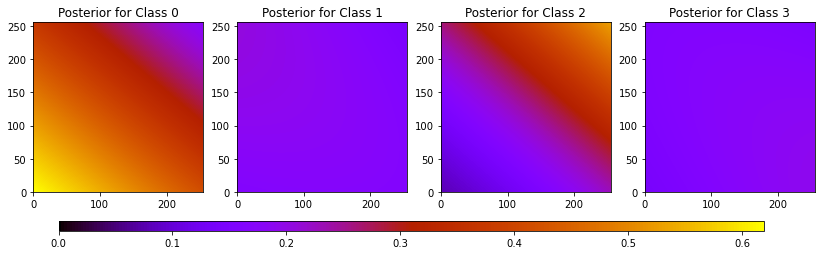

In [45]:
logreg = LogReg(num_classes=4, num_features=2, sigma= 2)

# Scaling of features for numerical reasons! 
scale = 1 / np.max(X)

# Train the classifier
_ = logreg.fit(X * scale, y, max_iter=200)

# Create a set of 'all' features in the limits
xx, yy = np.meshgrid(np.arange(0, 256, 1), np.arange(0, 256, 1))
mesh_features = np.c_[xx.ravel(), yy.ravel()]

# Get posteriors for the new test samples
PROB = logreg.compute_posteriors(mesh_features * scale)
lab.print_probabilities(PROB, (256, 256), 'Posterior', n_cls=4)

Again, we can plot the decision boundaries:

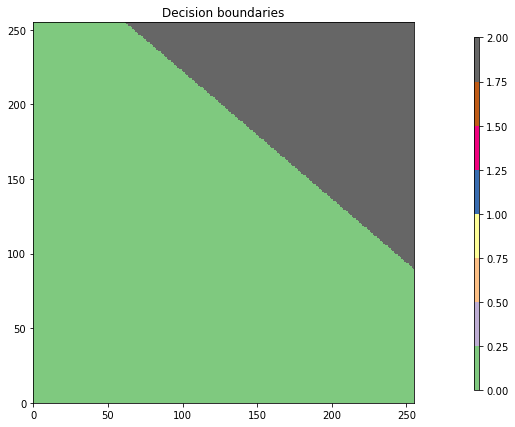

In [46]:
C = logreg.predict(mesh_features * scale)
lab.print_decision_boundaries(C, (256, 256))

### Exercise 1.2: Logistic regression with feature space transformation
__Implement__ the function ``transform_features`` in the cell below. It takes $X$, a $N\times2$ feature array, and returns $X2$, the transformed $N\times5$ feature array. Each row in $X2$ should contain the original features $(x, y)$ as well as the squares $(x^2, y^2)$ and the mixed product $(x\cdot y)$. For numerical reasons, a scaling of features (scale) needs to be applied to features before transformation.

In [47]:
def transform_features(X, scale):
    
    # YOUR CODE GOES HERE!
    
    XX = X * scale
    X2 = np.zeros((X.shape[0], 5))

    X2[:,:2] = XX
    X2[:,2:4] = np.square(XX)
    X2[:, 4] = np.multiply(XX[:, 0], XX[:, 1])
    
    return X2

__Run__ the following cell to transform the features of the training and test sets.

In [48]:
X2   = transform_features(X, scale)
X2_t = transform_features(X_t, scale)

The next cell will train a second classifier based on the transformed features.

weights:
 [[ 0.568  0.926  0.071  0.087  0.02   0.833]
 [-2.34   6.639  7.041 -3.958 -7.408  0.855]
 [-1.76   2.969  2.992 -1.215 -3.808  1.255]
 [-1.587  2.375  2.617 -1.037 -3.689  1.766]]


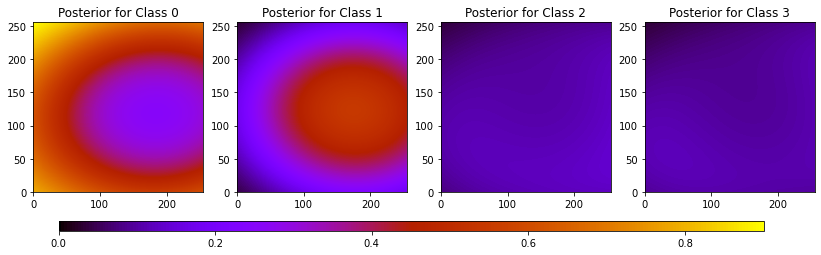

In [49]:
logreg2 = LogReg(num_classes=4, num_features=5, sigma= 2)
# logreg2.fit(X2, y)
logreg2.fit(X2, y,max_iter = 350)


# Get posteriors for the new test samples
PROB = logreg2.compute_posteriors(transform_features(mesh_features, scale))
lab.print_probabilities(PROB, xx.shape, 'Posterior', n_cls=4)

Again, we can plot the decision boundaries:

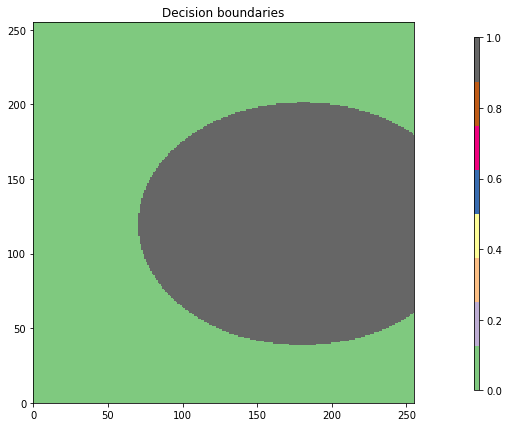

In [50]:
C = logreg2.predict(transform_features(mesh_features, scale))
lab.print_decision_boundaries(C, (256, 256))

### Exercise 1.3: Comparison and evaluation

Use your implementation of the function ``compute_quality_metrics``  from the previous Lab in the cell below.

Note that it should computes the following quality metrics (all in the range between 0 and 1):

- Precision per class (1D array)
- Recall per class (1D array)
- F1-score per class (1D array)
- Overall accuracy (scalar)
- Mean F1-score  (scalar)

The function takes the array of predictions $Y$, the corresponding reference labels $y$ and the number of classes $C$ as input.

In [51]:
def compute_quality_metrics(Y, y, C):

    # YOUR CODE GOES HERE!

    Y = Y.astype(int)
    y = y.astype(int)
    Matrix = np.zeros((C, C))

    # for i in range(len(Y)):
    #     if Y[i] == y[i]:
    #         Matrix[Y[i],Y[i]] += 1
    #     else:
    #         Matrix[Y[i],y[i]] += 1    


    #################### 2nd way to compute Matrix #####################        
    np.add.at(Matrix, (Y, Y), np.equal(Y, y))
    np.add.at(Matrix, (Y, y), np.logical_not(np.equal(Y, y)))

    # print("Matrix: \n", Matrix)
    
    diagonal = Matrix.diagonal()


    precisions = diagonal / (np.sum(Matrix, axis=1) + 1e-10)
    recalls = diagonal / (np.sum(Matrix, axis=0) + 1e-10)
    f1_scores = 2 / ((1 / precisions + 1 / recalls))
    
    overall_accuracy = np.sum(diagonal)/ len(Y)  
    # mean_f1_score = np.mean(f1_scores)
    mean_f1_score = np.sum(f1_scores) / C
    
    return precisions, recalls, f1_scores, overall_accuracy, mean_f1_score

__Run__ the next cell to test your implementation. The code computes and prints the overall accuracy for both datasets and both classifiers.

In [52]:
_, _, _, oa_lr_train, mf1_lr_train = compute_quality_metrics(logreg.predict(X * scale), y, 4)
_, _, _, oa_lr_test, mf1_lr_test = compute_quality_metrics(logreg.predict(X_t * scale), y_t, 4)

_, _, _, oa_lr2_train, mf1_lr2_train = compute_quality_metrics(logreg2.predict(X2), y, 4)
_, _, _, oa_lr2_test, mf1_lr2_test = compute_quality_metrics(logreg2.predict(X2_t), y_t, 4)

print('Overall Accur. | TRAIN-SET| TEST-SET\n' + '-' * 37)
print('LOG. REG.       |  {:.2%}  |  {:.2%}'.format(oa_lr_train, oa_lr_test))
print('LOG. REG. W/ TR.|  {:.2%}  |  {:.2%}'.format(oa_lr2_train, oa_lr2_test))
print('\n')
print(' Mean F1-Score  | TRAIN-SET| TEST-SET\n' + '-' * 37)
print('LOG. REG.       |  {:.2%}  |  {:.2%}'.format(mf1_lr_train, mf1_lr_test))
print('LOG. REG. W/ TR.|  {:.2%}  |  {:.2%}'.format(mf1_lr2_train, mf1_lr2_test))

Overall Accur. | TRAIN-SET| TEST-SET
-------------------------------------
LOG. REG.       |  42.44%  |  40.20%
LOG. REG. W/ TR.|  48.49%  |  47.80%


 Mean F1-Score  | TRAIN-SET| TEST-SET
-------------------------------------
LOG. REG.       |  29.10%  |  29.58%
LOG. REG. W/ TR.|  33.23%  |  33.56%


/var/folders/lr/gk77h9m92bn156hz39qw7q040000gn/T/ipykernel_85538/1733097971.py:27: RuntimeWarning: divide by zero encountered in true_divide
  f1_scores = 2 / ((1 / precisions + 1 / recalls))


__Write__ a brief discussion, which answers the following questions:
- Write a paragraph _(max. 12 lines)_ describing the main steps to train a logistic regression model? This should be answered w.r.t. the methodology, not the implementation and do not include any mathematical formula.
- What is the idea behind the regularization and how does the choice of $\sigma$ affect the results? Try different values for $\sigma$,  document and discuss the results. 
- Explain the idea of the quadratic expansion and the influence on the quality metrics. Would a cubic expansion make sense?
- How is an unseen feature vector classified (both models)?

#### Discussion:

#### 1. Write a paragraph _(max. 12 lines)_ describing the main steps to train a logistic regression model? This should be answered w.r.t. the methodology, not the implementation and do not include any mathematical formula.
    Training a logistic regression model involves several key steps. First, we gather a labeled dataset containing input features and corresponding class labels. Then, we split the dataset into a training set and a testing set. The logistic regression model is initialized with random weights and the training process begins. During training, the model's weights are iteratively adjusted using an optimization algorithm to minimize the cost or loss function. This process involves calculating the model's predictions, comparing them to the true labels, and updating the weights accordingly. The training continues for a specified number of iterations or until convergence is achieved. Finally, we evaluate the trained model using the testing dataset to assess its performance and determine its accuracy, precision, recall, and other metrics.  

#### 2. What is the idea behind the regularization and how does the choice of $\sigma$ affect the results? Try different values for $\sigma$,  document and discuss the results. 
    The concept of regularization is to prevent the model from overfitting. It is achieved by adding a regularization term to the loss function during training. When the model is too complex, it is prone to overfitting, that is, noise or random changes in overfitting training data, resulting in poor generalization ability of uns seen data. Therefore, through regularization, the complexity of the model can be limited. This can help avoid overfitting problems and improve the performance of the model on unknown data.  

    The results of varying $\sigma$ are recorded in the table below. The maximum number of iterations for training is set to 250 for logreg and 350 for logreg2.

    From the data in the table, we can observe that setting $\sigma$ to values that are too large or too small can lead to overfitting or underfitting issues, resulting in changes in accuracy. In this task, the appropriate range for $\sigma$ is between 0.5 and 3. sigma value below 0.5 resulted in a decrease in accuracy. On the other hand, values bigger than 3 did not lead to further improvement in accuracy. Therefore, in practical tasks, it is important to select the appropriate $\sigma$ parameter based on the specific model and training data to achieve better results.

    

| $\sigma$ | logreg_test Overall Accur. | logreg2_test Overall Accur. |
|:-:|:-:| :-:|
| None | 40.20% | 48.49% |
| 0.01 | 25.07% | 25.07% |
| 0.1  | 25.07% | 25.07% |
| 0.25 | 25.07% | 25.07% |
| 0.5  | 38.63% | 25.07% |
| 0.75 | 39.90% | 34.54% |
| 1 | 40.10% | 44.49% |
| 2 | 40.20% | 47.80% |
| 3 | 40.20% | 48.10% |
| 4 | 40.20% | 48.20% |
| 5 | 40.20% | 48.39% |
| ... | ... | ... |
| 10| 40.20% | 48.49% |
| ... | ... | ... |
| 100 | 40.20% | 48.49%  |
|  ...  | ... | ... |
| 1000  | 40.20% |  48.49% |


#### 3. Explain the idea of the quadratic expansion and the influence on the quality metrics. Would a cubic expansion make sense? 
    The idea of quadratic expansion is to obtain additional features by squaring the original features. This approach allows the model to capture the nonlinear relationship between the features and the target variable. However, it also increases the number of parameters of the model
    Adding a cubic expansion further enhances the model's ability to capture the nonlinear relationship. Cubic expansion allows the model to represent more complex, curvilinear patterns.
    However, the use of cubic expansions also increases the complexity of the model and the potential for overfitting, especially if the current data set is small. Therefore, cubic expansion is not required.

#### 4. How is an unseen feature vector classified (both models)?
    Both models have essentially the same steps in classification, but preprocess the data in different ways before classification.

    First we have trained two models, each with its own corresponding weights. Before classification, the data needs to be preprocessed to transform the unseen feature vectors. For example, here the second model needs to add squared terms。 Subsequently, the values of the unseen feature vectors are multiplied with the corresponding weights learned during the training step, and both need to take into account the regularization. The transformation is performed using the Sigmoid function, mapped to a value between 0 and 1, indicating the probability of the class to which the unseen feature vector belongs. The class to which the final maximum probability number belongs is the class that changes the unseen feature vector.

## Exercise 2: PyTorch basics
In this part you should get comfortable with the `pytorch` framework.
#### Binary toy dataset
We start by creating a toy data set for a binary classification problem. Each sample $\mathbf{x}_i$ consists of two features $x_0$ and $x_1$.

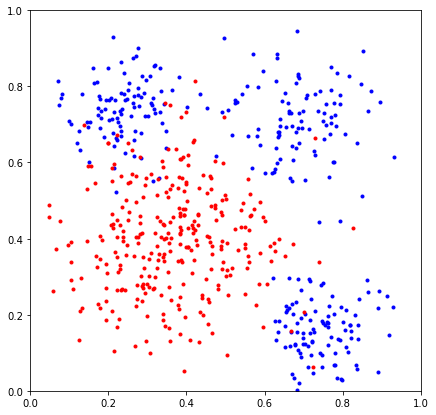

In [12]:
num_samples = 600
samples_C0 = np.vstack((np.random.randn(num_samples//6, 2) * 0.075 + np.array([[0.75, 0.15]]),  # Samples for class 0
                       np.random.randn(num_samples//6, 2) * 0.1 + np.array([[0.7, 0.72]]),
                       np.random.randn(num_samples//6, 2) * 0.075 + np.array([[0.25, 0.75]])))
samples_C1 = np.random.randn(num_samples//2, 2) * 0.15 + np.array([[0.35, 0.4]])                # Samples for class 1

all_samples = np.concatenate((samples_C0, samples_C1))                                          # Concat the samples
reference_values = np.concatenate((np.zeros(num_samples//2),                                    # Target labels
                                   np.ones(num_samples//2))).astype(dtype=np.float32)

matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize]                                    # Plot samples 
plt.plot(samples_C0[:,0], samples_C0[:,1], 'b.')
plt.plot(samples_C1[:,0], samples_C1[:,1], 'r.')
plt.xlim(0, 1); plt.ylim(0, 1); plt.show()

### Logistic regression with gradient descent
Because the logistic regression model is relatively simple and very close to the concept of neural networks, we start by implementing a logistic regression using the `pytorch` framework. The first step is to convert input samples and reference labels to pytorch tensors, here `X` and`Y`, respectively. The features of torch are mostly comparable to those of numpy. A `torch.tensor` is the fundamental class of the framework, comparable to the `numpy.ndarray` in numpy.

In [13]:
X = torch.tensor(all_samples, dtype=torch.float)  # A tensor can be created from a ndarray, here with explicid datatype
Y = torch.tensor(reference_values).float()        # Casting the datatype is also possible with the according functions
print(X.shape, Y.shape)      

torch.Size([600, 2]) torch.Size([600])


Next, we will set up the trainable parameters of the model. Remember that the probability $P$ of a feature $x$ for belonging to class 1 is defined as

$$P(x = (x_0, x_1)~~|~~C=1) = \sigma(w_0 \cdot x_0 + w_1 \cdot x_1 + b)$$

for a binary classification problem. Here, $\sigma$ is the sigmoid function:

$$\sigma(x) = \dfrac{1}{1+e^{-x}}$$

Three trainable parameters are required here:

In [14]:
w_0 = torch.tensor([0.0], requires_grad=True)     # All parameters are initialized as a scalar with zero value
w_1 = torch.tensor([0.0], requires_grad=True)     # 'requires_grad' enables automatic differentiation
b   = torch.tensor([0.0], requires_grad=True)
params = [w_0, w_1, b]

The next cell performs one update step. __Run the cell multiple times__, to see how the parameters change and the cross entropy loss shrinks.

In [15]:
print('Values of w0/w1/b:     {:.4f} / {:.4f} / {:.4f}'.format(        # Print the current values of the parameters.
    float(w_0.data), float(w_1.data), float(b.data)))                  # The values can be accessed by the 'data' field

P = torch.sigmoid(w_0*X[:,0] + w_1*X[:,1] + b)                         # Compute the output for all samples  
P = P.view(-1)                                                         #   and flatten to a 1D tensor

E = -1 * torch.mean((Y)*torch.log(P) + (1 - Y)*torch.log(1 - P))       # Computation of the CE loss
print('Value of loss E:       {:.5f}'.format(float(E.data)))

E.backward()                        # The backward function will compute the gradients for all parameters,
                                    #  that the tensor depends on (here, E depends on w_0, w_1 and b)

print('Gradients of w0/w1/b:  {:.4f} / {:.4f} / {:.4f}'.format(        # The gradients are stored in the respective 
    float(w_0.grad.data), float(w_1.grad.data), float(b.grad.data)))   #   tensors and are accessed via 'grad.data'

LR = 0.5                            # Define a learning rate and 
for p in params:
    p.data.add_(-LR * p.grad.data)  #  update the parameters (opposite direction of the gradients)
    p.grad.data.zero_()             #  each call of 'backward' would accumulate the gradients so we set them to zero

Values of w0/w1/b:     0.0000 / 0.0000 / 0.0000
Value of loss E:       0.69315
Gradients of w0/w1/b:  0.0482 / 0.0353 / -0.0000


### Exercise 2.1: Training loop
__Complete__ the function `train()` in which the logistic regression model is trained for `num_iter` iterations with gradient descent and a learning rate of `LR`. After training has finished, the function should compute and return the overall accuracy of the last predictions `OA`, a list of all losses `Es` and the final values of the parameters.

In [16]:
def train(LR, num_iter):
    Es = []                                        # Append cross entropy loss of each iteration to this list
    w_0 = torch.tensor([0.0], requires_grad=True)  # Overwrite / initialize the parameters (hard reset)
    w_1 = torch.tensor([0.0], requires_grad=True)
    b   = torch.tensor([0.0], requires_grad=True)
    params = [w_0, w_1, b]
    
    # YOUR CODE GOES HERE

    i = 0
    while i < num_iter:
        posteriors = torch.sigmoid(w_0 * X[:,0] + w_1 * X[:,1] + b)
        posteriors = posteriors.view(-1)
        E = -1 * torch.mean((Y) * torch.log(posteriors) + (1 - Y) * torch.log(1 - posteriors))
        Es.append(float(E.data))

        E.backward()

        for p in params:
            p.data = p.data.add(-LR * p.grad.data)
            p.grad.data.zero_()

 
 
        i+=1

    threshold = 0.5
    predicted = (posteriors >= threshold).to(torch.float32)
    correct = torch.eq(predicted, Y).sum().item()
    
    OA = correct / Y.size(0)

    #
    f_params = [float(p.data) for p in params]     # Store final parameters as float values
    return Es, OA, f_params

In the next cell, the classifier is trained with different learning rates. The plot will show the loss over training iterations. Use this as a check for your implementation.

LR: 0.5, OA: 75.667%
LR: 0.1, OA: 75.667%
LR: 0.01, OA: 74.000%


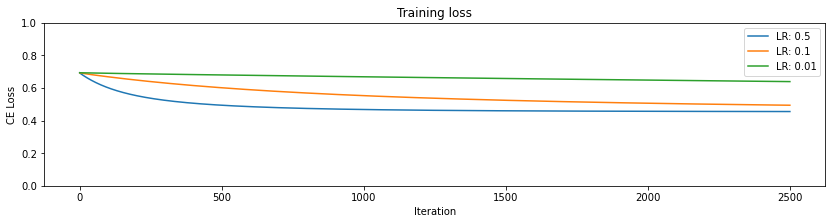

In [17]:
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize//2]  

all_f_params = []
LRs = [0.5, 0.1, 0.01]
for LR in LRs:
    Es, OA, f_params = train(LR, 2500)
    all_f_params.append(f_params)
    print('LR: {}, OA: {:.3%}'.format(LR, OA))
    plt.plot(Es, label='LR: {}'.format(LR))
    plt.title('Training loss')

plt.ylabel("CE Loss"); plt.xlabel("Iteration")
plt.legend(); plt.ylim(0, 1); plt.show()

__Visualize__ the decision boundaries:

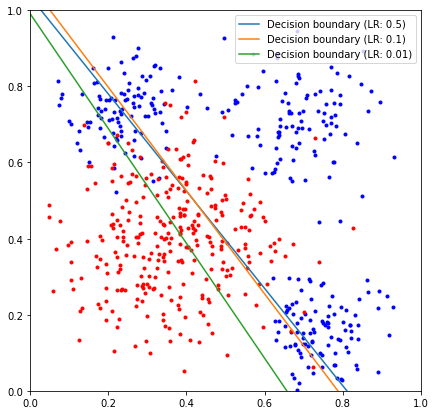

In [18]:
matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize]  

plt.plot(samples_C0[:, 0], samples_C0[:, 1], 'b.')
plt.plot(samples_C1[:, 0], samples_C1[:, 1], 'r.')

x0, x1 = 0.0, 1.0
for i, ((w_0i, w_1i, b_i), LR) in enumerate(zip(all_f_params, LRs)):    
    y0 = (-x0 * w_0i - b_i) / w_1i
    y1 = (-x1 * w_0i - b_i) / w_1i
    plt.plot([x0, x1], [y0, y1], label= 'Decision boundary (LR: {})'.format(LR))
plt.legend(); plt.xlim(0, 1); plt.ylim(0, 1); plt.show()

### Exercise 2.2: Neural networks
Before we start with neural networks, please  read the next two cells __carefully!__ Here, the class `torch.nn.Module` is introduced. It is used to model a network architecture. In the next cell the logistic regression is implemented as such a module:

In [19]:
class LogReg(nn.Module):                # A module is created as a class which is derived from torch.nn.Module
    
    def __init__(self):                 # The __init__ method is implicitly called whenever a new instance is created
        super(LogReg, self).__init__()  #  - Parents' __init__ method must be called (passing the current class)
        self.fcD = nn.Linear(2, 1)      #  - Defining submodules e.g. dense or convolutional layers
                                        #    the `Linear` module creates a dense layer. 
                                        #    Arguments are number of in / out neurons and 
                                        #    whether to use a bias or not (default is true)
        
    def forward(self, x):               # The 'forward' method describes how input is mapped to the output
                                        # (It is common to reuse a single variable in sequential networks - here, x)
        x = self.fcD(x)                 # First operation: pass input(x) through dense layer
        x = torch.sigmoid(x)            # Second operation: apply non-linarity
        return x

When using torch modules, the computation of the loss as well as the update steps can be simplified. This is shown in the next cell. 

Overall accuracy: 75.667%


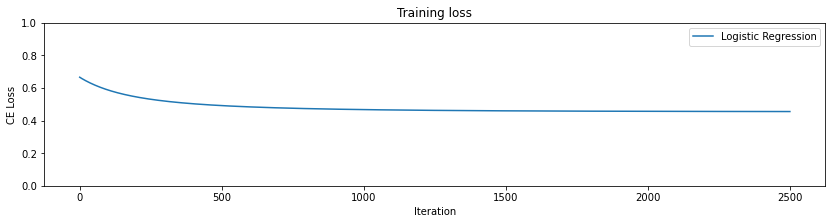

In [20]:
IT = 2500         # Hyperparameters: - Number of training iterations (Steps)
LR = 0.5          #                  - Learning rate

net = LogReg()                                  # Initialize the network
optimizer = optim.SGD(net.parameters(), lr=LR)  # Define the optimizer, here SGD: Stochastic Gradient Descent
                                                # The optimizer performs the update step and resets gradients

Ls = []                         #  We want to keep track of the loss over iterations
criterion = nn.BCELoss()        #  Loss models are used to compute loss, here: BCE Binary Cross Entropy 

for i in range(IT):             # Training loop:
    optimizer.zero_grad()       #   Reset gradients
    P = net(X)                  #   Feed forward step
    P = P.view(-1)              #   Flatten the pridictions to 1D-tensor
    loss = criterion(P, Y)      #   Feed predictions and reference to the loss model
    loss.backward()             #   Back propagation (compute gradients for all variables)
    optimizer.step()            #   Perform gradient descent
    Ls.append(float(loss.data)) #   Store loss (converted from tensor to float)

predicted_labels = np.round(P.data.numpy())                     # Compute labels by rounding (threshold = 0.5)
corrects = np.sum(predicted_labels == Y.data.numpy())           # Count correct predictions
print('Overall accuracy: {:.3%}'.format(corrects/num_samples))  # Compute and show overall accuracy

matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize//2]             # Plot cross entropy
plt.ylabel("CE Loss"); plt.xlabel("Iteration")
plt.title('Training loss')
plt.plot(Ls, label='Logistic Regression'); plt.ylim(0, 1); plt.legend(); plt.show()

Run the next cell to __visualize__ the decision boundaries of the model:

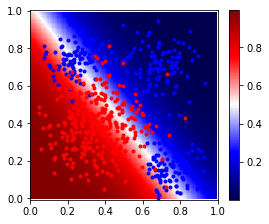

In [21]:
matplotlib.rcParams['figure.figsize'] = [0.6*PlotSize, 0.5*PlotSize]  

xx, yy = np.meshgrid(np.arange(0, 1, 1/150), np.arange(0, 1, 1/150))
grid_samples = np.c_[xx.ravel(), yy.ravel()].reshape(-1,2).astype(np.float32)

Z = net(torch.tensor(grid_samples)).data.numpy().reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap="seismic", shading='auto')
plt.plot(samples_C0[:, 0]*1, samples_C0[:, 1]*1, 'b.')
plt.plot(samples_C1[:, 0]*1, samples_C1[:, 1]*1, 'r.')

plt.axis("equal"); plt.colorbar(); plt.xlim(0,1); plt.ylim(0,1); plt.show()

Now __implement__ a multilayer perceptron (neural network). The architecture should have:

- A variable number of hidden layers (specified by the argument `layers`)
- A variable number of neurons in each hidden layer (specified by the argument `neurons`)
- Use the `tanh` non-linearity for the hidden layers. (E.g. by using `torch.tanh()`)
- Use the `sigmoid` non-linearity for the output layer. 

Note that for a variable number of layers you have to use either a
[ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) or the [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module.


In [22]:
class NN(nn.Module): 
    def __init__(self, layers, neurons):
        super(NN, self).__init__()
        
        # YOUR CODE GOES HERE
        self.input_layer = nn.Linear(2,neurons)
        self.hidden_layer = nn.ModuleList([nn.Linear(neurons,neurons) for _ in range(layers)])
        self.output_layer = nn.Linear(neurons,1)
        #self.activation = torch.tanh()

    def forward(self, x):
        
        # YOUR CODE GOES HERE
        x = self.input_layer(x)
        for hidden in self.hidden_layer:
            x = torch.tanh(hidden(x))
        x = torch.sigmoid(self.output_layer(x)) 
        return x
        #

The training loop remains similar, but several `settings` are compared. Also training is now done using mini batches. __Add your own new settings__  and observe the effect of changing the hyper-parameters of the architecture and the training.

setting 1) LR: 0.5, #Layers: 2, #Neurons: 8, Batch size 64
Overall accuracy: 95.667%


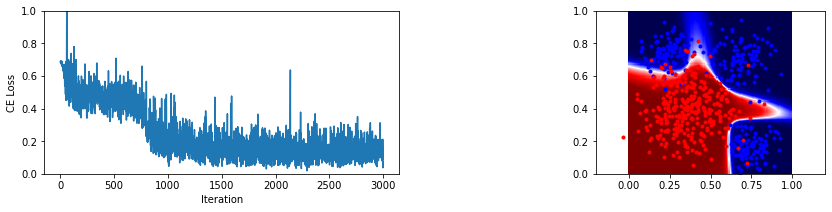

In [23]:
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize//2]  

#  The settings are stored as a list of 5-tuples. The parameters are:
# (iterations, learning rate, num. layers, num. neurons per layer, batch size) 

settings = [(3000, 0.5, 2, 8, 64),]  # currently, one example setting; ADD YOUR NEW ONES TO THE LIST

for si, (IT, LR, layers, neurons, batch_size) in enumerate(settings):
    print("setting {}) LR: {}, #Layers: {}, #Neurons: {}, Batch size {}".format(
        si+1, LR, layers, neurons, batch_size))
    
    Ls = []
    criterion = nn.BCELoss()
    net = NN(layers, neurons)
    optimizer = optim.SGD(net.parameters(), lr=LR)

    for i in range(IT):
        idx = torch.randperm(X.size(0))[:batch_size]
        x, y = X[idx], Y[idx]
        optimizer.zero_grad()  
        pred = net(x).view(-1)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()  
        Ls.append(float(loss.data))

    pred = net(X).view(-1)
    predicted_labels = np.round(pred.data.numpy())
    corrects = np.sum(predicted_labels == Y.data.numpy())
    print('Overall accuracy: {:.3%}'.format(corrects/num_samples))

    plt.subplot(1,2,1)
    plt.plot(Ls); plt.ylim(0, 1); plt.ylabel("CE Loss"); plt.xlabel("Iteration")

    Z = net(torch.tensor(grid_samples)).data.numpy().reshape(xx.shape)

    plt.subplot(1,3,3)
    plt.pcolormesh(xx, yy, Z, cmap="seismic", shading='auto')
    plt.plot(samples_C0[:, 0]*1, samples_C0[:, 1]*1, 'b.')
    plt.plot(samples_C1[:, 0]*1, samples_C1[:, 1]*1, 'r.')

    plt.axis("equal"); plt.xlim(0,1); plt.ylim(0,1); plt.show()

### Exercise 2.3: Discussion

__Write a discussion__ based on the results for the settings in the previous cell. Run the code using several settings and discuss the influence of the hyper-parameters: learning rate, number of layers, number of neurons per layer and batch size. A recommended strategy is to use one baseline setting and then add scenarios in which one hyper-parameter is changed, respectively. For each hyper-parameter, your discussion should consider both the theoretical viewpoint and what you observe in the experiments.

#### Discussion:


#### Learning rate:
    From setting 1 to setting 4 i just change the learning rate. The learning rate from setting 2 is biggest(0.8), and this result is best. The result from setting 4 is the worst. So in this case, i will say, the larger the learning rate, the better the result.

#### Number of layers:
    From setting 5 to setting 7 i just change the number of layers. The result from setting 6 is best(95.167%). From these results it can be concluded that more layers may be not better results.

#### Numer of neurons per layer:
    From setting 8 to setting 10 i just change the number of neurons per layer. The more neurons per layer, the better accuracy we can get. But the number of neurons reaches a critical value, and the results don't get any better.

#### Batch size:
    From Setting 11 to setting 13 i just change the number of batch size. The results just like a parabola. Bigger of smaller batch size means not better result.

    The influnce of hyperparameters is very complex. Because the result is not linear. Bigger or samller hyperparameters means not better result. We should combine different situations and suitable parameters to achieve better results.

## Exercise 3: Image classification
In the previous exercise, we have learned how to implement a perceptron (Logistic Regression) and a Multilayer Perceptron for binary classification using a toy dataset. In this exercise, we are going to apply the same models for classifying images using the __pytorch__ framework on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains images of hand written digits. Each image has 28 x 28 pixels and one channel. The classes correspond to the digits 0-9. The given function `lab.MnistGenerator()` will download the dataset (if not already available). You can run the next cell several times to see some samples. The images in the MNIST dataset are already split into:

- 60.000 images for training
- 10.000 images for testing

We will preserve 1.000 training images as a validation dataset.

Example for class 4:


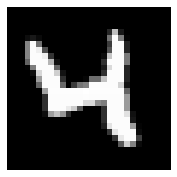

In [24]:
gen = lab.MnistGenerator()
Xs, Ys = gen.get_train_batch()

r = np.random.randint(len(Ys))
print('Example for class {}:'.format(int(Ys[r])))

matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize//2]  
plt.imshow(Xs[r][0], cmap='gray', vmin=0.0, vmax=255.0); plt.axis('off'); plt.show()

### Exercise 3.1: Defining the models
We will train two different models on the dataset:

__1. Logistic regression:__

- No hidden layer, direct mapping from (normalized) input to output.

__2. Multilayer perceptron:__

- One hidden layer with 256 neurons and tanh non-linearity.

#### Hints:

- In each forward pass __normalize__ the images to a range of -1 to 1 (input values are in range 0 to 255).
- Use `x=x.view(-1, N)` to __flatten__ a feature map (with `N` elements). This is required when passing images or feature maps to dense layers.
- In all two cases __the last layer must not have a non-linearity__ (because the softmax is included in the loss formulation we will use later)

In [25]:
class LogReg(nn.Module):
    def __init__(self):
        # ENTER YOUR CODE HERE

        super(LogReg,self).__init__()  # super() is used to give access to methods and properties of a parent or sibling class.
        self.fc1 = nn.Linear(28*28,10)
        self.activation = nn.Tanh()

    def forward(self, x):
        # ENTER YOUR CODE HERE
        #x = self.layers(x)
        x = self.activation(x)  #tanh is one activation functions. It is defined as, the hyperbolic tangent function having an average range of (-1, 1)
        x = x.view(-1,28*28)  #flatten a feature map
        output = self.fc1(x)


        return output

In [26]:
class MLP(nn.Module):
    def __init__(self):
        # ENTER YOUR CODE HERE

        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,10)
        self.activation = nn.Tanh()
    def forward(self, x):
        # ENTER YOUR CODE HERE
        x = self.activation(x)  #tanh is one activation functions. It is defined as, the hyperbolic tangent function having an average range of (-1, 1)
        x = x.view(-1,28*28)  #flatten a feature map
        x = self.fc1(x)
        output = self.fc2(x)
        #x = self.fc2(x)  #tanh is one activation functions. It is defined as, the hyperbolic tangent function having an average range of (-1, 1)
        #output = self.activation(x)
        return output

#### Training loop
The training loop is given in the next cell. It is similar to the previous training loop, but additionally, an evaluation on the validation is performed.

__Complete__ the function to include the evaluation on test set.

In [27]:
def train_network(gen, net, optimizer, num_iter):
    Ls = []
    TBAs = []
    VAs = []
    
    net.train()
    criterion = nn.CrossEntropyLoss()
    
    for i in range(num_iter):
        X, Y = gen.get_train_batch()
        num_samples = float(len(Y))
        
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        
        optimizer.zero_grad()  
        pred = net(TX)
        loss = criterion(pred, TY)
        loss.backward()
        optimizer.step()  

        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        TBA = num_correct/num_samples
        print('\rIt {}/{}, CE: {:.3f}, Batch Acc.: {}/{} = {:.1%}'.format(
            i, num_iter, loss.data, num_correct, len(Y), TBA), end='')
        
        # Compute accuracy of validation set
        
        X, Y = gen.get_validation_batch()
        num_samples = float(len(Y))
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        net.eval()
        pred = net(TX)
        net.train()
        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        VA = num_correct/num_samples
        
        Ls.append(float(loss.data))
        TBAs.append(TBA)
        VAs.append(VA)
        
    # Compute accuracy of test set
        
    X, Y = gen.get_test_batch()
    
    # ENTER YOUR CODE HERE
    #
    # 1. Convert X and Y into Tensors
    # 2. Set the network into inference mode
    # 3. Make predictions

    num_samples = float(len(Y))
    TX = torch.tensor(X).view(-1, 1, 28, 28)
    TY = torch.tensor(Y).long()
    net.eval()
    pred = net(TX)
    net.train()
    Vs, Is = torch.max(pred, -1)
    num_correct = np.sum(Is.data.numpy() == Y)
    TA = num_correct / num_samples
    
    
    CM = confusion_matrix(Y, Is)
    return Ls, TBAs, VAs, CM

### Exercise 3.2: Training

In this section the models are trained (with different settings).
In each cell, __choose appropriate hyperparameters__ to achieve stable results. In particular choose:

- Batch size `BS`
- Number of iterations `IT`
- Learning rate `LR`

#### Training: Logistic Regression

It 999/1000, CE: 0.919, Batch Acc.: 6/8 = 75.0%%
Final validation accuracy: 93.2%

TEST SET ACCURACY: 88.7%



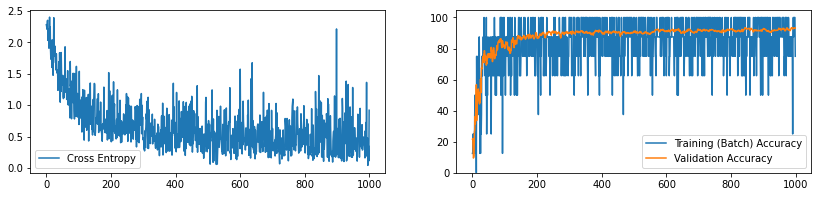

In [28]:
BS = 8
LR = 0.02
IT = 1000

gen = lab.MnistGenerator(BS) # Data generator
net = LogReg() 

optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize//2]
lab.print_summary(Ls, TBAs, VAs, CM)

Because the logistic regression has no intermediate layers, the the learned weights can be  interpreted visually. The following code will show the feature maps as images. You should be able to see patterns that correspond to the digits 0-9.

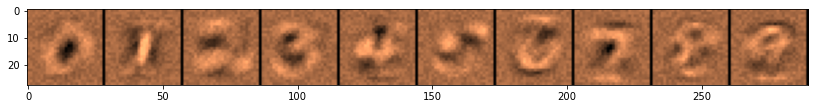

In [29]:
Is = []
weights = net.fc1.weight.data.numpy()
for i in range(10):
    Is.append(weights[i].reshape((28,28)))
    Is.append(np.ones((28,1))*np.min(weights))
I = np.hstack(Is)
plt.imshow(I, cmap='copper')
plt.show()

#### Training: Multilayer perceptron (Neural network)

It 999/1000, CE: 1.001, Batch Acc.: 6/8 = 75.0%%
Final validation accuracy: 92.6%

TEST SET ACCURACY: 89.1%



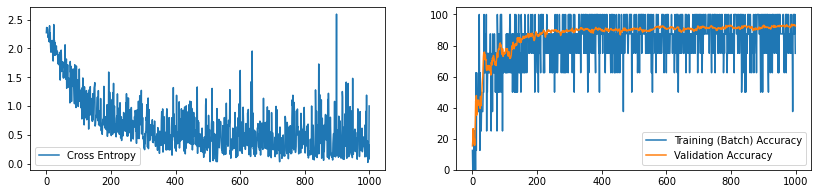

In [30]:
BS = 8
LR = 0.02
IT = 1000

gen = lab.MnistGenerator(BS)
net = MLP() 
optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
lab.print_summary(Ls, TBAs, VAs, CM)

### Exercise 3.3: Discussion

__Write a discussion__ which answers the following aspects and questions: 

- During all experiments, what was the main influence of learning rate and batch size?
- Discuss the performance of both models (LogReg and MLP). What might be the reasons behind the differences in the performance you observe?
- Describe existing techniques that can be used to improve the classification results of a MLP.

#### Discussion:

*Write the discussion here. Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

- #### **During all experiments, what was the main influence of learning rate and batch size?**

    **1.learning rate**:  

        Learning rate controls the step size at which the model parameters are updated during training.This means that it can affect the speed of convergence and performance of the model. If the learning rate is too low, the model may converge very slowly, requiring a large number of iterations to reach good performance. If the learning rate is too high, the model may fail to converge or even diverge, resulting in unstable training and poor performance. So it is common to start with a relatively high learning rate and gradually decrease it during training to achieve better convergence and fine-tuning of the model.  
    
    **2.batch size**:  
    
        Batch size determines the number of samples processed in each forward and backward pass during training. This means that it can also affect the speed of convergence and performance of the model. A larger batch size can speed up the training process as more samples are processed in parallel, but larger batch sizes require more memory and  can lead to a decrease in the quality of the updates due to increased noise.

- #### **Discuss the performance of both models (LogReg and MLP). What might be the reasons behind the differences in the performance you observe?** 

        MLP has better performance than LogReg. The posiible reasons are Model Complexity. The MLP model has a hidden layer with 256 neurons and uses a non-linear activation function (tanh), while the Logistic Regression model has no hidden layers and directly maps the inputs to outputs. The MLP's hidden layer allows it to capture more complex and non-linear relationships in the data, which can lead to improved performance compared to the linear Logistic Regression model.

- #### **Describe existing techniques that can be used to improve the classification results of a MLP.** 

    **1.Normalization of input data**:

        Normalizing the input data can help improve the convergence and performance of an MLP. Common normalization techniques include scaling the input features to have zero mean and unit variance or scaling them to a specific range, such as [0, 1] or [-1, 1].

    **2.Activation functions**:

        Choosing appropriate activation functions for the MLP's hidden layers can have a significant impact on its performance. Commonly used activation functions include ReLU (Rectified Linear Unit), sigmoid, and tanh. ReLU is often preferred due to its ability to mitigate the vanishing gradient problem and promote faster convergence.

    **3.Initialization of weights**:

        Proper initialization of the MLP's weights can facilitate better training. Techniques such as Xavier/Glorot initialization or He initialization help initialize the weights with suitable scales to ensure a balanced learning process.  

    **4.Optimization algorithms**:

        The choice of optimization algorithm can influence the MLP's convergence and classification results. Techniques like stochastic gradient descent (SGD), Adam, or RMSprop are commonly used to optimize the MLP's weights. Adaptive learning rate methods, such as Adam, can adaptively adjust the learning rate based on the gradients' statistics, leading to faster convergence.  

    **5.Regularization techniques**:

        Regularization techniques can prevent overfitting and improve the generalization ability of an MLP. Common regularization methods include L1 and L2 regularization (weight decay), dropout, and batch normalization. These techniques help reduce over-reliance on specific features or neurons and promote more robust learning.  

    **6.Data augmentation**:

        Data augmentation techniques artificially increase the size of the training dataset by applying various transformations to the input data, such as rotations, translations, flips, and scaling. Data augmentation can help improve the MLP's ability to generalize by exposing it to a wider variety of training examples.  
    
    **7.Ensemble methods**:

        Ensembling involves combining multiple MLP models to make predictions. Techniques such as bagging (bootstrap aggregating) and boosting (e.g., AdaBoost) can be used to create ensembles that leverage the diversity of individual models to improve classification results.  



**That's all we've done. We hope you'll  enjoy reading it.   (Gruppe 3)**